In [1]:
import sys
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


sys.path.append("../..")
from burgers.plot import plot_1d_image
from model import Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
######### DATA #########
def initial_condition(x: np.ndarray) -> np.ndarray:
    return 6.0 * np.exp(-3.0 * x)

def exact_sol(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    return 6.0 * np.exp(-3.0 * x - 2.0 * t)

# Initial condition
ic_x = np.random.uniform(low=0.0, high=2.0, size=(500,1))
ic_t = np.zeros((500,1))
ic_u = initial_condition(ic_x)

# PDE Condition
pde_x = np.random.uniform(low=0.0, high=2.0, size=(500, 1))
pde_t = np.random.uniform(low=0.0, high=1.0, size=(500, 1))
pde_zeros = np.zeros((500, 1))



In [3]:
model = Model(in_dim=2, hidden_dim=5, out_dim=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [4]:
## PDE loss
def f(x: torch.Tensor, t: torch.Tensor, model: Model) -> torch.Tensor:
    u = model(x, t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    ## du/dx - 2du/dt - u
    pde = u_x - 2 * u_t - u
    return pde

In [5]:
### (3) Training / Fitting
epochs = 10000
best_loss = 99999999.0

loss_ic = []
loss_pde = []
loss_total = []
loss_test = []

best_model_state_dict = copy.deepcopy(model.state_dict())
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()  # to make the gradients zero

    # Initial condition
    pt_ic_x = Variable(torch.from_numpy(ic_x).float(), requires_grad=False).to(device)
    pt_ic_t = Variable(torch.from_numpy(ic_t).float(), requires_grad=False).to(device)
    pt_ic_u = Variable(torch.from_numpy(ic_u).float(), requires_grad=False).to(device)
    net_bc_out = model(pt_ic_x, pt_ic_t)  # output of u(x,t)
    mse_u = F.mse_loss(net_bc_out, pt_ic_u)

    # PDE condition
    pt_x_collocation = Variable(
        torch.from_numpy(pde_x).float(), requires_grad=True
    ).to(device)
    pt_t_collocation = Variable(
        torch.from_numpy(pde_t).float(), requires_grad=True
    ).to(device)
    pt_all_zeros = Variable(
        torch.from_numpy(pde_zeros).float(), requires_grad=False
    ).to(device)
    f_out = f(pt_x_collocation, pt_t_collocation, model)
    mse_f = F.mse_loss(f_out, pt_all_zeros)

    # Combining the loss functions
    loss = mse_u + mse_f

    loss.backward()  # This is for computing gradients using backward propagation
    optimizer.step()  # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if best_loss > loss.item():
        best_loss = loss.item()
        best_model_state_dict = copy.copy(model.state_dict())
        print(epoch, "Traning Loss:", best_loss)

    loss_ic.append(mse_u.item())
    loss_pde.append(mse_f.item())
    loss_total.append(loss.item())

last_model_state_dict = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_state_dict)

0 Traning Loss: 2.788506031036377
1 Traning Loss: 2.7813689708709717
2 Traning Loss: 2.774282932281494
3 Traning Loss: 2.767249345779419
4 Traning Loss: 2.7602689266204834
5 Traning Loss: 2.7533416748046875
6 Traning Loss: 2.746469497680664
7 Traning Loss: 2.739652395248413
8 Traning Loss: 2.732891082763672
9 Traning Loss: 2.726186990737915
10 Traning Loss: 2.719539165496826
11 Traning Loss: 2.7129502296447754
12 Traning Loss: 2.706418752670288
13 Traning Loss: 2.699946403503418
14 Traning Loss: 2.693533420562744
15 Traning Loss: 2.687180280685425
16 Traning Loss: 2.6808865070343018
17 Traning Loss: 2.674654245376587
18 Traning Loss: 2.6684823036193848
19 Traning Loss: 2.6623713970184326
20 Traning Loss: 2.6563217639923096
21 Traning Loss: 2.6503336429595947
22 Traning Loss: 2.644407272338867
23 Traning Loss: 2.638542413711548
24 Traning Loss: 2.6327390670776367
25 Traning Loss: 2.626997947692871
26 Traning Loss: 2.621318817138672
27 Traning Loss: 2.615701198577881
28 Traning Loss: 2.6

<All keys matched successfully>

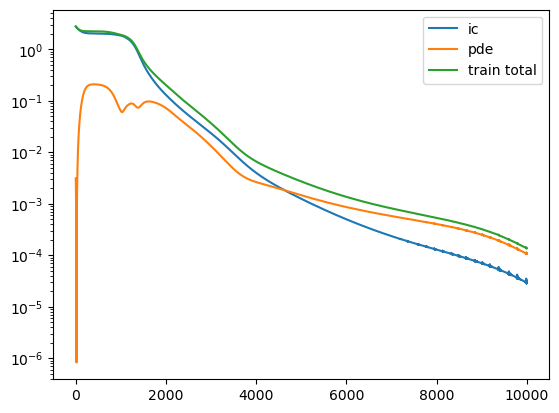

In [6]:
plt.plot(loss_ic, label="ic")
plt.plot(loss_pde, label="pde")
plt.plot(loss_total, label="train total")
# plt.plot(loss_test, label="test")

plt.legend()
plt.yscale("log")
plt.show()

# Plot

In [7]:
position = np.arange(0, 2, 0.02, dtype=np.float32)
time = np.arange(0, 1, 0.02, dtype=np.float32)

xt = np.stack(np.meshgrid(position, time), axis=-1)  # [S, N, 2]
x = torch.tensor(xt[..., 0], device=device).reshape(-1, 1)
t = torch.tensor(xt[..., 1], device=device).reshape(-1, 1)

with torch.no_grad():
    model.eval()
    pred_field = model(x, t).cpu().numpy()
    true_field = exact_sol(x.cpu().numpy(), t.cpu().numpy())

true_trajectory = true_field.reshape(len(time), len(position), 1)
pred_trajectory = pred_field.reshape(len(time), len(position), 1)
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=4.6972e-03, in range (-0.0086658, 0.057446003)


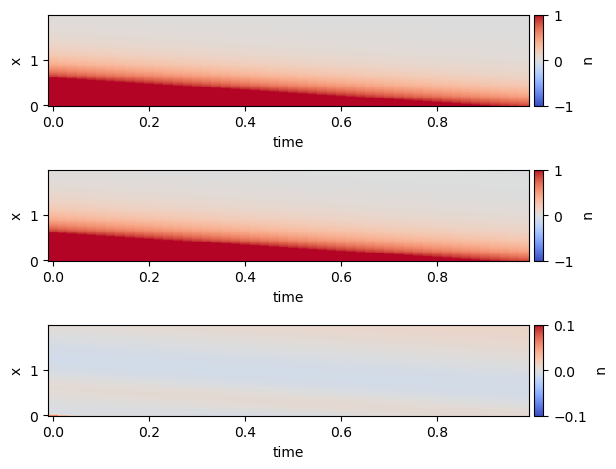

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

im1 = plot_1d_image(
    ax1, time, position, true_trajectory, to_periodic=False, rasterized=True
)
cbar = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax1.set_xlabel("time")
ax1.set_ylabel("x")

im2 = plot_1d_image(
    ax2, time, position, pred_trajectory, to_periodic=False, rasterized=True
)
cbar = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax2.set_xlabel("time")
ax2.set_ylabel("x")

im3 = plot_1d_image(
    ax3, time, position, error, to_periodic=False, rasterized=True, lim=(-0.1, 0.1)
)
cbar = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax3.set_xlabel("time")
ax3.set_ylabel("x")

fig.tight_layout()
fig.show()

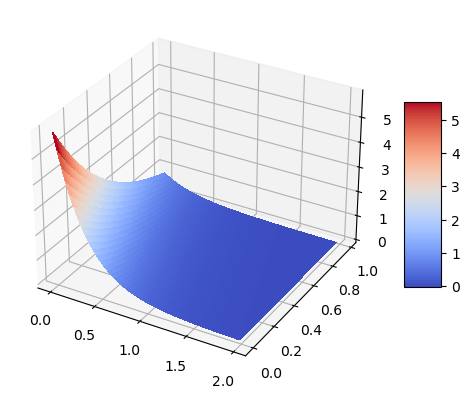

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = np.arange(0, 2, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = model(pt_x, pt_t)
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(
    ms_x, ms_t, ms_u, cmap="coolwarm", linewidth=0, antialiased=False
)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()